# Investigation of alternative to baseline-dependent averaging.

The idea is to partition the visibility into inner and outer parts. The density of samples in the inner parts of the uv plane is much greater so we can afford to use coarser gridding but with the same field of view as used for the
further out data. The computation required for the inner, dense region of the Fourier plane is just a complex addition, instead of a complete gridding kernel complex add. This approach should rival two-region baseline-dependent averaging.

In this notebook, we investigate the consequences of imaging in this way.

In [1]:
%matplotlib inline

import os
import sys

from time import clock

sys.path.append(os.path.join('..', '..'))

from matplotlib import pylab

pylab.rcParams['agg.path.chunksize'] = 10000
pylab.rcParams['figure.figsize'] = (10.0, 10.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import constants as const
from astropy.wcs.utils import pixel_to_skycoord

from matplotlib import pyplot as plt
from matplotlib.pyplot import cm 

from arl.visibility.operations import create_visibility
from arl.skymodel.operations import create_skycomponent
from arl.image.operations import show_image, export_image_to_fits, qa_image, create_image_from_array, reproject_image
from arl.fourier_transforms.fft_support import extract_mid
from arl.image.iterators import raster_iter
from arl.visibility.iterators import vis_timeslice_iter
from arl.util.testing_support import create_named_configuration
from arl.fourier_transforms.ftprocessor import *
from arl.fourier_transforms.compress import compress_visibility

import logging
log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))

Construct the SKA1-LOW configuration

In [2]:
low = create_named_configuration('LOWBD2')

We create the visibility holding the vis, uvw, time, antenna1, antenna2, weight columns in a table. The actual visibility values are zero.

In [3]:
times = numpy.arange(- numpy.pi / 4.0, + numpy.pi * 1.001 / 4.0, numpy.pi / 8)
frequency = numpy.linspace(0.95e8,1.05e8,5)

reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox=2000.0)
vt = create_visibility(low, times, frequency, weight=1.0, phasecentre=phasecentre, spectral_mode='channel',
                      reffrequency=1e8, channelwidth=5e7, npol=1) 

create_visibility: Visibility has 654080 rows, total size 1.857 GB


Create a model to serve as the image specification

In [4]:
model = create_image_from_visibility(vt, npixel=1024, npol=1, cellsize=0.00001)

create_wcs_from_visibility: Parsing parameters to get definition of WCS
create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, frequency 95000000.0 Hz, and bandwidth 2500000.0 Hz
create_wcs_from_visibility: uvmax = 28318.581830 wavelengths
create_wcs_from_visibility: Critical cellsize = 0.000018 radians, 0.001012 degrees
create_wcs_from_visibility: Cellsize          = 0.000010 radians, 0.000573 degrees
image.operations: created image of shape (5, 1, 1024, 1024), size 0.469 (GB)


Now calculate the density of samples in the Fourier plane

get_ftprocessor_params: effective uv cellsize is 48.8 wavelengths
weight_gridding: Performing uniform weighting


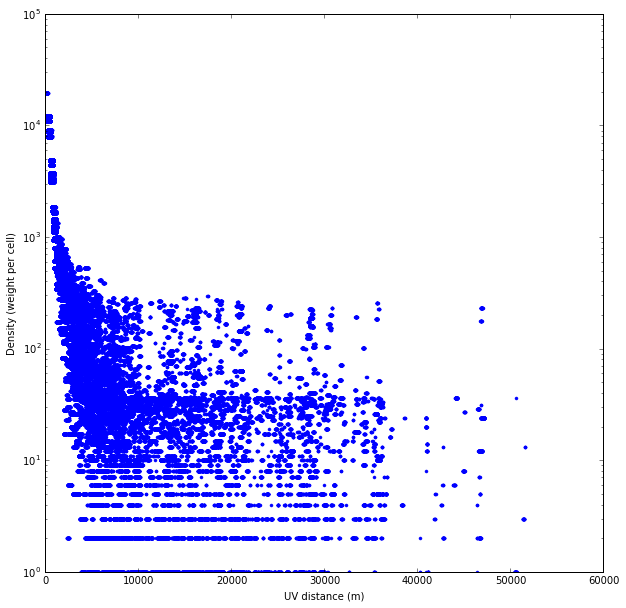

In [5]:
vts, density, densitygrid = weight_visibility(vt, model)
plt.clf()
uvdist = numpy.sqrt(vts.u*vts.u+vts.v*vts.v)
plt.semilogy(uvdist[density[:,0,0]>0.0], density[:,0,0][density[:,0,0]>0], '.')
plt.xlabel('UV distance (m)')
plt.ylabel('Density (weight per cell)')
plt.show()

First use invert_timeslice to get the benchmark time.

In [6]:
def norm_sumwt(result, sumwt):
    nchan=result.shape[0]
    npol=result.shape[1]
    for chan in range(nchan):
        for pol in range(npol):
            result[chan,pol,...] /= sumwt[chan,pol] 
    return result


ts = clock()
full_psf, full_sumwt = invert_2d(vt, model, dopsf=True, nprocessor=1)
full_psf.data = norm_sumwt(full_psf.data, full_sumwt)

criterion = 'medianabs'
qa_full = qa_image(full_psf).data[criterion]
t_full = clock() - ts
log.debug("Invert_2d took %.1f seconds" % (t_full))
export_image_to_fits(full_psf, 'imaging-twopart_psf_full.fits')

invert_2d: inverting using 2d transform
get_ftprocessor_params: effective uv cellsize is 48.8 wavelengths
image.operations: created image of shape (5, 1, 1024, 1024), size 0.469 (GB)
Invert_2d took 54.7 seconds


In [21]:
def invert_twopart(vis, im, dopsf=False, invert=invert_2d, **kwargs):
    """Divide vis into inner and outer, image separately, and add
    
    Cut down on processing by gridding the inner (dense) part of Fourier plane with box gridding, 
    and the outer (sparse) part by more accurate PSWF gridding.
    """

    # Partition the visibility data
    boundary = get_parameter(kwargs, "inner", 0.125)
    visr = numpy.sqrt(vis.u*vis.u+vis.v*vis.v)
    uvmax = numpy.max(visr)
    inner_rows = (numpy.abs(visr)  < boundary * uvmax) & (numpy.abs(visr) <  boundary * uvmax)
    outer_rows = (numpy.abs(visr) >= boundary * uvmax) & (numpy.abs(visr) >= boundary * uvmax)

    inner_vis = create_visibility_from_rows(vis, inner_rows)
    outer_vis = create_visibility_from_rows(vis, outer_rows)
    log.debug("Split in inner (%d rows) and outer (%d rows)" % (numpy.sum(inner_rows), numpy.sum(outer_rows)))

    # Do the outer baselines with standard parameters
    outer_params = copy.copy(kwargs)
    outer_im = create_image_from_visibility(outer_vis, **outer_params)
    outer_result, outer_sumwt = invert(outer_vis, outer_im, dopsf, **outer_params)
    outer_result.data = norm_sumwt(outer_result.data, outer_sumwt)
    
    # Compress the inner baselines
    cellsize = get_parameter(kwargs, "cellsize", abs(numpy.pi * im.wcs.wcs.cdelt[0] / 180.0))
    npixel = get_parameter(kwargs, "npixel", outer_result.data.shape[3])
    padding = get_parameter(kwargs, "padding", 2)
    
    inner_params = copy.copy(kwargs)
    inner_params["npixel"] = int(round(npixel * boundary))
    inner_params['cellsize'] = cellsize/boundary  
    inner_params['padding'] = int(round(padding/boundary)) 

    inner_im = create_image_from_visibility(inner_vis, **inner_params)
    inner_vis_compressed = compress_visibility(inner_vis, inner_im, **inner_params)
    inner_result, inner_sumwt = invert(inner_vis_compressed, outer_im, dopsf, **outer_params)
    inner_result.data = norm_sumwt(inner_result.data, inner_sumwt)
 
    result = create_image_from_visibility(outer_vis, **outer_params)
    result_sumwt = inner_sumwt + outer_sumwt
    nchan=result.data.shape[0]
    npol=result.data.shape[1]
    for chan in range(nchan):
        for pol in range(npol):
            result.data[chan,pol,...] = (inner_sumwt[chan, pol] * inner_result.data[chan,pol,...] + 
                                         outer_sumwt[chan, pol] * outer_result.data[chan,pol,...])
    
    return result, result_sumwt 

Now do a range of partitions

create_visibility_from_rows: Created view into visibility table
create_visibility_from_rows: Created view into visibility table
Split in inner (241054 rows) and outer (413026 rows)
create_wcs_from_visibility: Parsing parameters to get definition of WCS
create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, frequency 95000000.0 Hz, and bandwidth 2500000.0 Hz
create_wcs_from_visibility: uvmax = 28318.581830 wavelengths
create_wcs_from_visibility: Critical cellsize = 0.000018 radians, 0.001012 degrees
create_wcs_from_visibility: Cellsize          = 0.000010 radians, 0.000573 degrees
image.operations: created image of shape (5, 1, 1024, 1024), size 0.469 (GB)
invert_2d: inverting using 2d transform
get_ftprocessor_params: effective uv cellsize is 48.8 wavelengths
image.operations: created image of shape (5, 1, 1024, 1024), size 0.469 (GB)
create_wcs_from_visibility: Parsing parameters to get definition of WCS
create_wcs_from_visibility: Defining

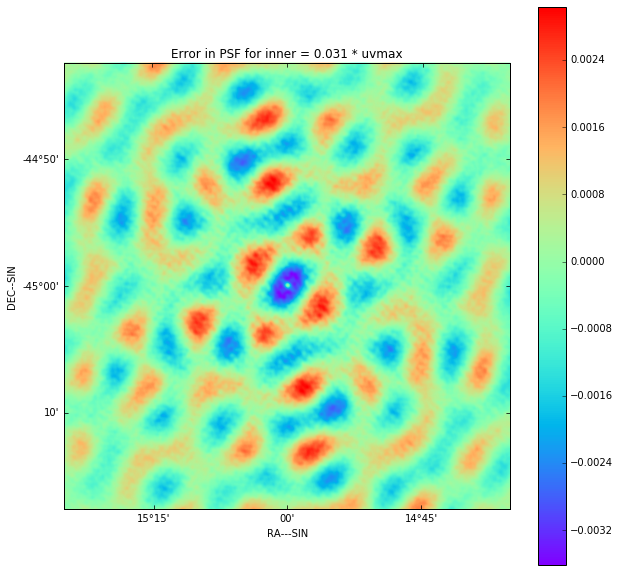

create_visibility_from_rows: Created view into visibility table
create_visibility_from_rows: Created view into visibility table
Split in inner (316102 rows) and outer (337978 rows)
create_wcs_from_visibility: Parsing parameters to get definition of WCS
create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, frequency 95000000.0 Hz, and bandwidth 2500000.0 Hz
create_wcs_from_visibility: uvmax = 28318.581830 wavelengths
create_wcs_from_visibility: Critical cellsize = 0.000018 radians, 0.001012 degrees
create_wcs_from_visibility: Cellsize          = 0.000010 radians, 0.000573 degrees
image.operations: created image of shape (5, 1, 1024, 1024), size 0.469 (GB)
invert_2d: inverting using 2d transform
get_ftprocessor_params: effective uv cellsize is 48.8 wavelengths
image.operations: created image of shape (5, 1, 1024, 1024), size 0.469 (GB)
create_wcs_from_visibility: Parsing parameters to get definition of WCS
create_wcs_from_visibility: Defining

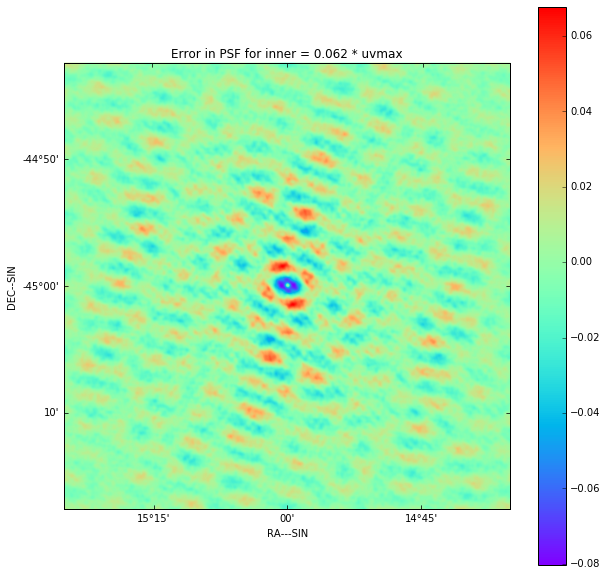

create_visibility_from_rows: Created view into visibility table
create_visibility_from_rows: Created view into visibility table
Split in inner (406249 rows) and outer (247831 rows)
create_wcs_from_visibility: Parsing parameters to get definition of WCS
create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, frequency 95000000.0 Hz, and bandwidth 2500000.0 Hz
create_wcs_from_visibility: uvmax = 28318.581830 wavelengths
create_wcs_from_visibility: Critical cellsize = 0.000018 radians, 0.001012 degrees
create_wcs_from_visibility: Cellsize          = 0.000010 radians, 0.000573 degrees
image.operations: created image of shape (5, 1, 1024, 1024), size 0.469 (GB)
invert_2d: inverting using 2d transform
get_ftprocessor_params: effective uv cellsize is 48.8 wavelengths
image.operations: created image of shape (5, 1, 1024, 1024), size 0.469 (GB)
create_wcs_from_visibility: Parsing parameters to get definition of WCS
create_wcs_from_visibility: Defining

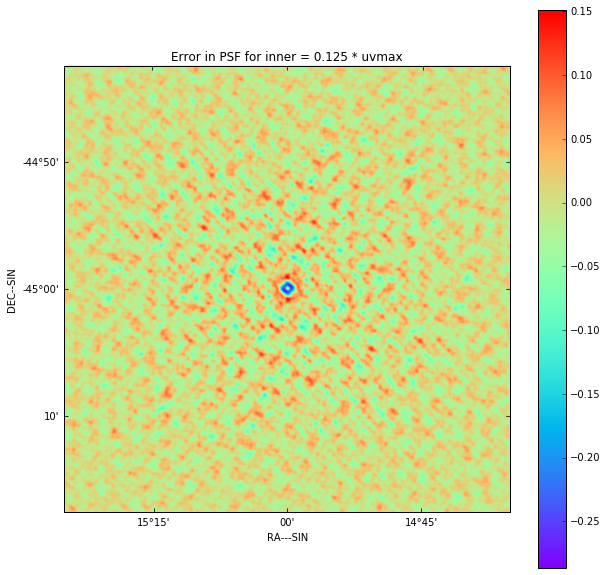

create_visibility_from_rows: Created view into visibility table
create_visibility_from_rows: Created view into visibility table
Split in inner (508832 rows) and outer (145248 rows)
create_wcs_from_visibility: Parsing parameters to get definition of WCS
create_wcs_from_visibility: Defining Image at <SkyCoord (ICRS): (ra, dec) in deg
    ( 15., -45.)>, frequency 95000000.0 Hz, and bandwidth 2500000.0 Hz
create_wcs_from_visibility: uvmax = 28318.581830 wavelengths
create_wcs_from_visibility: Critical cellsize = 0.000018 radians, 0.001012 degrees
create_wcs_from_visibility: Cellsize          = 0.000010 radians, 0.000573 degrees
image.operations: created image of shape (5, 1, 1024, 1024), size 0.469 (GB)
invert_2d: inverting using 2d transform
get_ftprocessor_params: effective uv cellsize is 48.8 wavelengths
image.operations: created image of shape (5, 1, 1024, 1024), size 0.469 (GB)
create_wcs_from_visibility: Parsing parameters to get definition of WCS
create_wcs_from_visibility: Defining

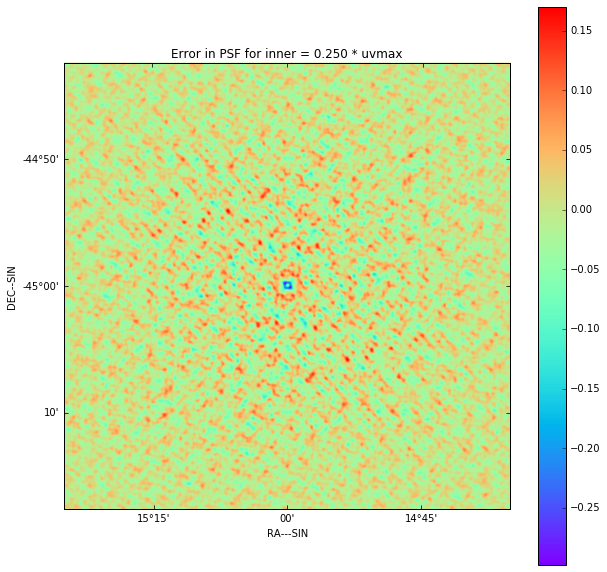

In [23]:
inners = [1.0/32.0, 1.0/16.0, 1.0/8.0, 1.0/4.0]
times = []
qas = []
for inner in inners:
    ts = clock()
    twopart_psf, twopart_sumwt = invert_twopart(vt, model, dopsf=True, invert=invert_2d, 
                                                inner=inner, npixel=1024, cellsize=0.00001)
    twopart_psf.data = norm_sumwt(twopart_psf.data, twopart_sumwt)
    export_image_to_fits(twopart_psf, 'imaging-twopart_psf_full%.3f.fits' % inner)   

    t_twopart = clock() - ts
    log.debug("Invert_twopart using inner=%.3f took %.1f seconds" % (inner, t_twopart))
    times.append(t_twopart)
    twopart_psf.data-=full_psf.data

    thisqa = qa_image(twopart_psf)
    print(thisqa)
    qas.append(thisqa.data[criterion]) 
    
    show_image(twopart_psf)
    plt.title("Error in PSF for inner = %.3f * uvmax" % inner)
    plt.show()

[41.50555900000006, 37.28116800000009, 29.308469999999943, 22.89111700000001]
[0.00056100829206038108, 0.0084678670401650176, 0.018234468311280276, 0.020583158055693919]


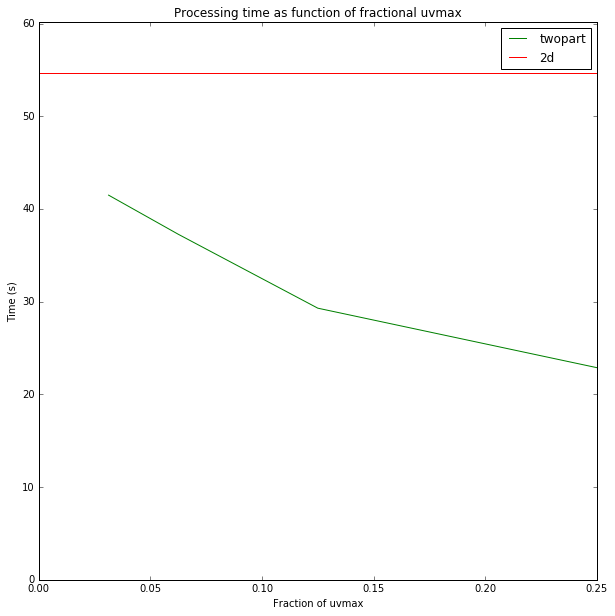

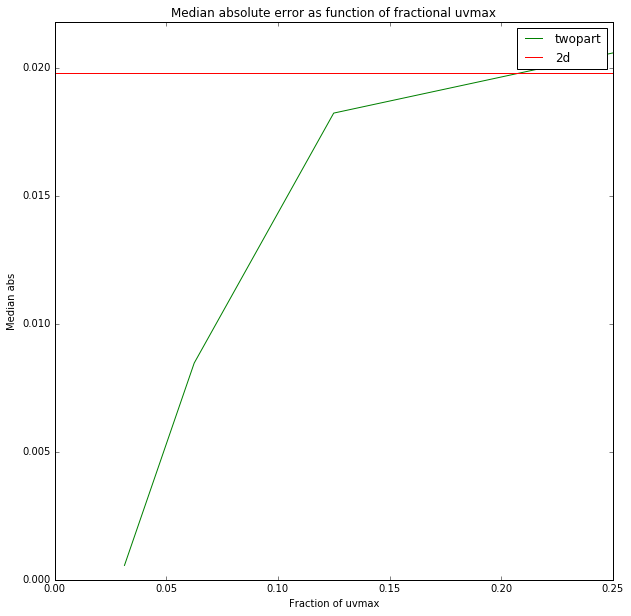

In [24]:
print(times)
print(qas)
plt.clf()
plt.plot(inners, times, label='twopart', color='g')
plt.axhline(t_full, label='2d', color='r')
plt.xlabel('Fraction of uvmax')
plt.ylabel('Time (s)')
plt.title('Processing time as function of fractional uvmax')
plt.ylim(0.0, 1.1*t_full)
plt.legend()
plt.show()
plt.clf()
plt.plot(inners, qas, label='twopart', color='g')
plt.axhline(qa_full, label='2d', color='r')
plt.xlabel('Fraction of uvmax')
plt.ylabel('Median abs')
plt.ylim(0.0, 1.1*qa_full)

plt.legend()
plt.title('Median absolute error as function of fractional uvmax')
plt.show()